### Bibliotecas

In [1]:
from src.clean_directory import *
from src.functions_prep import *
from src.functions_dff import *
from src.metrics import *

import numpy as np
import pandas as pd
from datetime import datetime
import pywt
import json
import seaborn as sns
sns.set(font_scale=1,
        rc={'axes.labelsize':12, 'axes.labelcolor':'black', 'axes.titlecolor':'black', 'axes.titlesize':18,
            'text.color':'black', 'xtick.labelsize':10, 'xtick.color':'black', 'ytick.labelsize':10,
            'ytick.color': 'black','legend.fontsize':12, 'font.family':['serif'], 'axes.grid':False,
            'font.serif':['Times New Roman'], 'axes.facecolor':'white', 'axes.edgecolor':'black', 'axes.linewidth':0.5})
sns.set_style("ticks")
import matplotlib.pyplot as plt
plt.rc('figure', dpi=100, labelsize=12, titlesize=18, autolayout=True)
plt.rc('axes' , labelsize=12, labelcolor='black', titlecolor='black', titlesize=18)
plt.rc('xtick', labelsize=10, color='black')
plt.rc('ytick', labelsize=10, color='black')
plt.rc('legend', fontsize=12)
plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', color='black')
plt.rc('savefig', dpi=600, format='png')
plt.rc('grid', color='gray', linewidth=0.5, linestyle='--')

import keras_tuner as kt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from functools import partial
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro, pearsonr, t

### Tunning e classificação

In [2]:
# Carregar csv
data = pd.read_csv('datasets/EEG_energy_wavelets.csv')
data = data.sample(frac=1).reset_index(drop=True)
X = data.drop('group', axis=1).values
y = data['group'].values

# Criar 5 conjuntos de dados divididos em treino, teste
skf1 = StratifiedKFold(n_splits=10)
skf2 = StratifiedKFold(n_splits=5)

datasets = []
for train_index, test_index in skf1.split(X, y):
    datasets.append((X[train_index], X[test_index], y[train_index], y[test_index]))
# for train_index, test_index in skf2.split(X, y):
#     datasets.append((X[train_index], X[test_index], y[train_index], y[test_index]))

# Variáveis de controle
input_units = X.shape[1]
output_units = 1
objective = kt.Objective('val_loss', direction='min')
monitor_er = 'val_loss'
epochs_tunning = 100
patience_tunning = 20
epochs_fit = 1000
patience_fit = 100
scores = {}
acc_scores = {'MLP-tuned': []}

#### MLP Tuning

In [108]:
clean_dir()
# del hp
from keras_tuner import HyperParameters as hp
hp = hp()
hp.Int('batch_size', 32, 128, step=32)

es = EarlyStopping(monitor=monitor_er, verbose=1, patience=patience_tunning, restore_best_weights=True)

tuner_MLP = kt.Hyperband(build_model_MLP, objective,
                        directory='hyperband_tuner',
                        hyperparameters=hp,
                        max_epochs=epochs_tunning,
                        overwrite=True)
time = datetime.now()
tuner_MLP.search(datasets[0][0], datasets[0][2], validation_data=(datasets[0][1], datasets[0][3]),
                 epochs=epochs_tunning, verbose=1, callbacks=[es])
time_process = datetime.now() - time
print(f"Tempo de processamento: {time_process}")
#254 trials
#Time process: 24m 12.6s

Trial 254 Complete [00h 00m 16s]
val_loss: 0.2775475084781647

Best val_loss So Far: 0.15827570855617523
Total elapsed time: 00h 24m 12s
INFO:tensorflow:Oracle triggered exit


In [109]:
best_hps = tuner_MLP.get_best_hyperparameters(num_trials=1)[0]
best_model_MLP = tuner_MLP.hypermodel.build(best_hps)
best_model_MLP.build(input_shape=(None, input_units))
best_model_MLP.summary()

best_hps_MLP = tuner_MLP.get_best_hyperparameters()[0].values
best_hps_MLP = dict(sorted(best_hps_MLP.items()))

print('Melhores parâmetros:\n')
print(best_hps_MLP)
      # 'lr: ', best_model_MLP.optimizer.lr.numpy())

#salvar dicionários com os melhores parâmetros
with open('results/best_hps_MLP.json', 'w') as f:
      best_hps_MLP = {k: v for k, v in best_hps_MLP.items() if 'tuner' not in k}
      json.dump(best_hps_MLP, f, indent=4)

best_model_MLP.save('results/best_model_MLP.h5py')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 96)                12192     
                                                                 
 dense_5 (Dense)             (None, 64)                6208      
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 35,041
Trainable params: 35,041
Non-trainable params: 0
_________________________________________________________________
Melhores parâmetros:

{'activation_in': 'relu', 'a

#### MLP Classificação

In [110]:
#Treinando melhor modelo com CV

best_batch_size = tuner_MLP.get_best_hyperparameters()[0].values['batch_size']
es = EarlyStopping(monitor=monitor_er, verbose=1, patience=patience_fit, restore_best_weights=True)

fits_MLP = []
cvscores_MLP = []
fits, fprs, tprs, rocs_aucs, accs = [], [], [], [], []
recalls, specificitys, precisions, f1s = [], [], [], []
time = datetime.now()
for dataset in datasets:
    print('\nFold: ', len(fits_MLP)+1)
    
    #carregar melhor modelo
    best_model_MLP = tf.keras.models.load_model('results/best_model_MLP.h5py')
    # best_model_MLP = tuner_MLP.hypermodel.build(best_hps)
   
    fit_MLP = best_model_MLP.fit(dataset[0], dataset[2], validation_split=0.2, batch_size=best_batch_size,
                                 epochs = epochs_fit, callbacks = [es])

    fits_MLP.append(fit_MLP)

    y_pred = best_model_MLP.predict(dataset[1]).reshape(-1)

    #Calcular Acurácia, Sensibildiade/Recall, Especificidade, Precisão e F1
    eval = get_evaluations(dataset[3], y_pred)
    fprs.append(eval['fpr']), tprs.append(eval['tpr']), rocs_aucs.append(eval['roc_auc'])
    accs.append(eval['acc'])
    recalls.append(eval['recall'])
    specificitys.append(eval['specificity'])
    precisions.append(eval['precision'])
    f1s.append(eval['f1'])

acc_scores = save_acc_scores(acc_scores, 'MLP-tuned', accs)
scores = save_avg_eval(scores, 'MLP-tuned', fprs, tprs, rocs_aucs, accs, recalls, specificitys, precisions, f1s)
time_process = datetime.now() - time
print(f"Tempo de processamento: {time_process}")
#Time process: 1m 51.4s


Fold:  1
Epoch 1/1000
18/18 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6934 - val_accuracy: 0.4733
Epoch 2/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.4733
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5429 - val_loss: 0.6896 - val_accuracy: 0.6723
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.7064 - val_loss: 0.6321 - val_accuracy: 0.7524
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.5704 - accuracy: 0.7538 - val_loss: 0.5108 - val_accuracy: 0.7573
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4453 - accuracy: 0.8097 - val_loss: 0.4372 - val_accuracy: 0.8155
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.3817 - accuracy: 0.8322 - val_loss: 0.3831 - val_accuracy: 0.

<Figure size 640x480 with 0 Axes>

C:\Users\abner\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


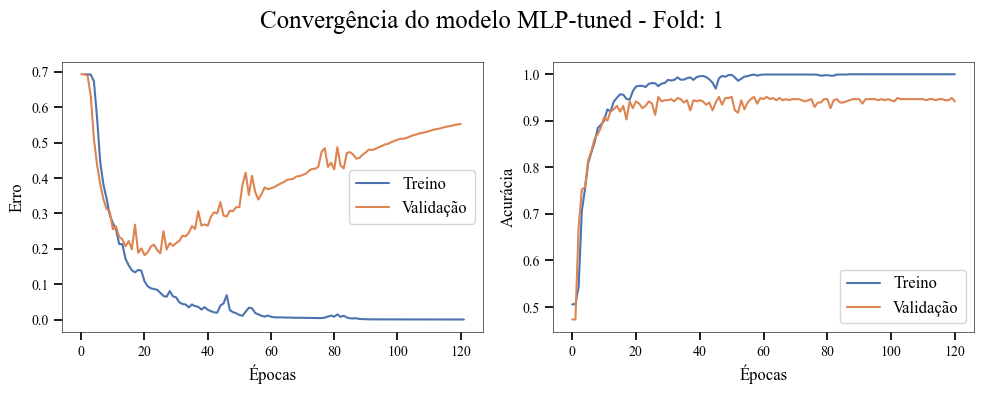

<Figure size 640x480 with 0 Axes>

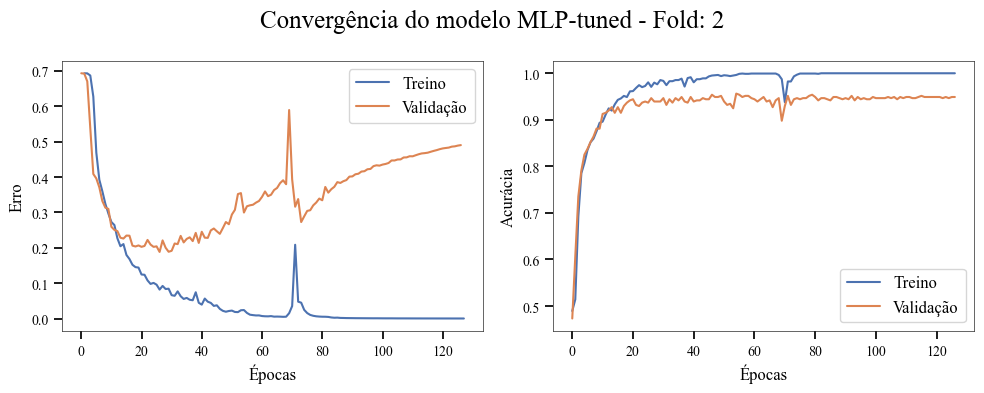

<Figure size 640x480 with 0 Axes>

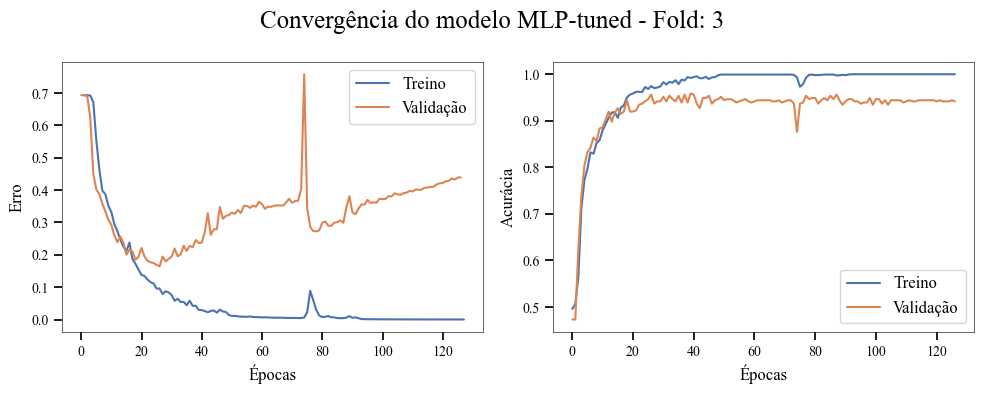

<Figure size 640x480 with 0 Axes>

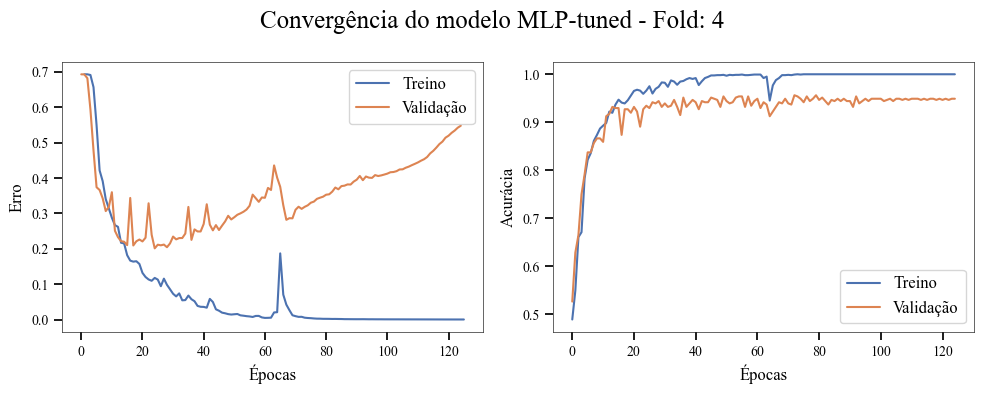

<Figure size 640x480 with 0 Axes>

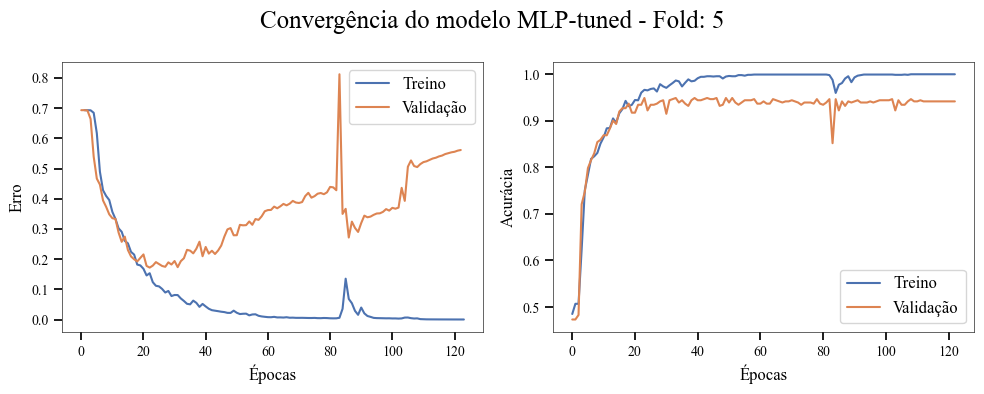

<Figure size 640x480 with 0 Axes>

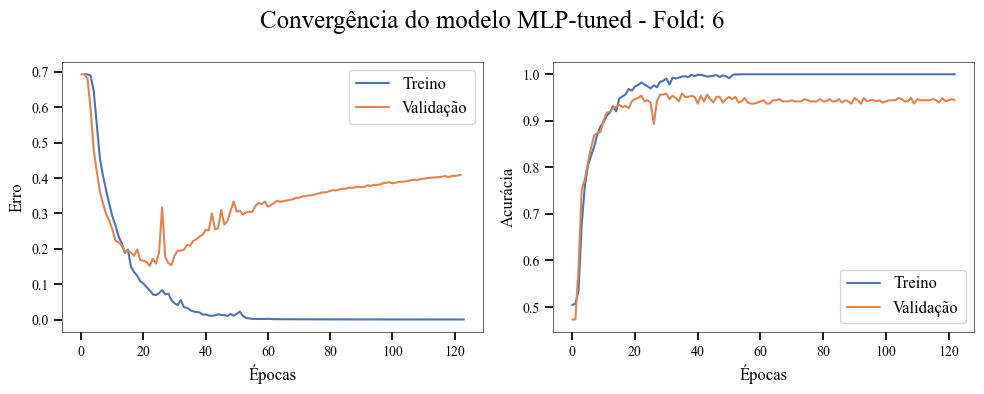

<Figure size 640x480 with 0 Axes>

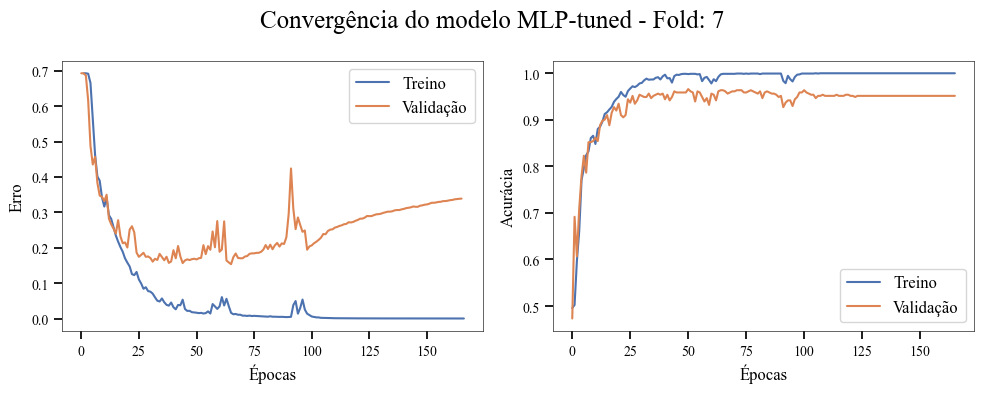

<Figure size 640x480 with 0 Axes>

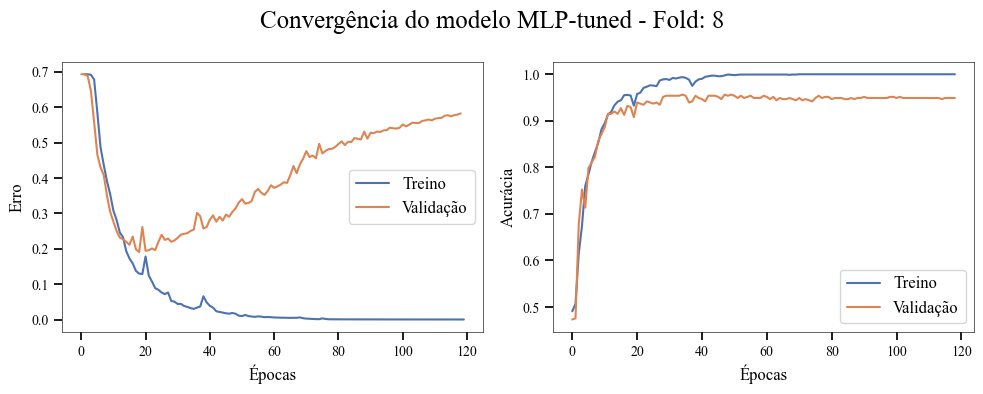

<Figure size 640x480 with 0 Axes>

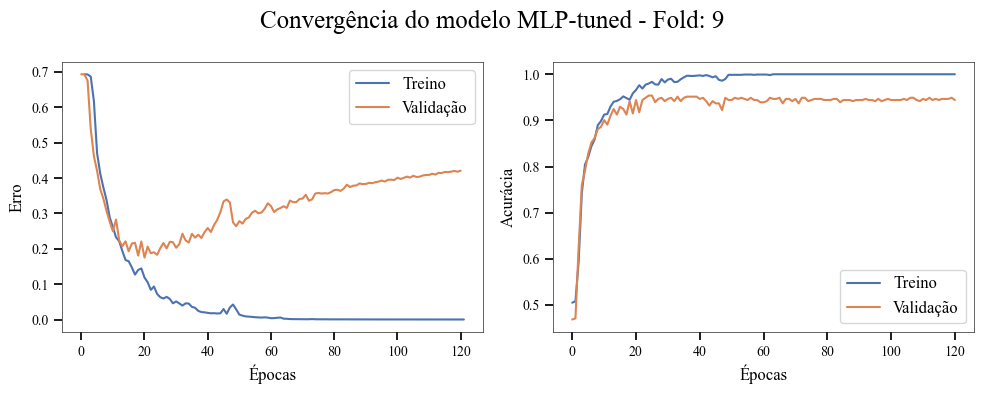

<Figure size 640x480 with 0 Axes>

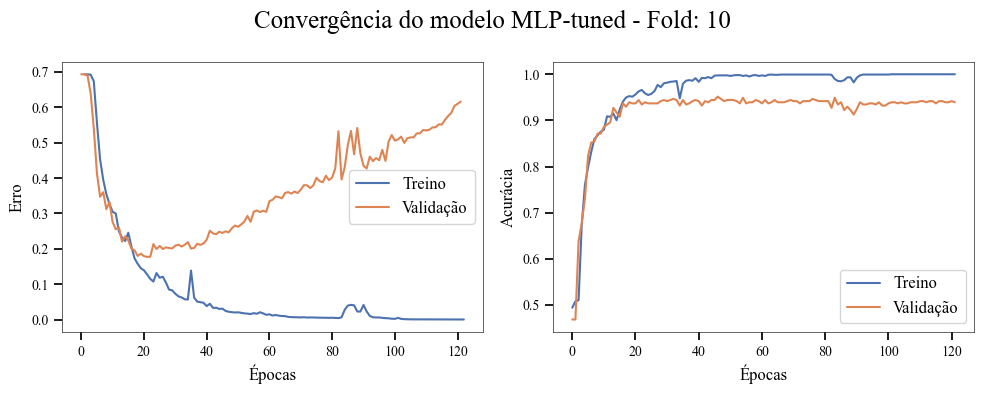

<Figure size 640x480 with 0 Axes>

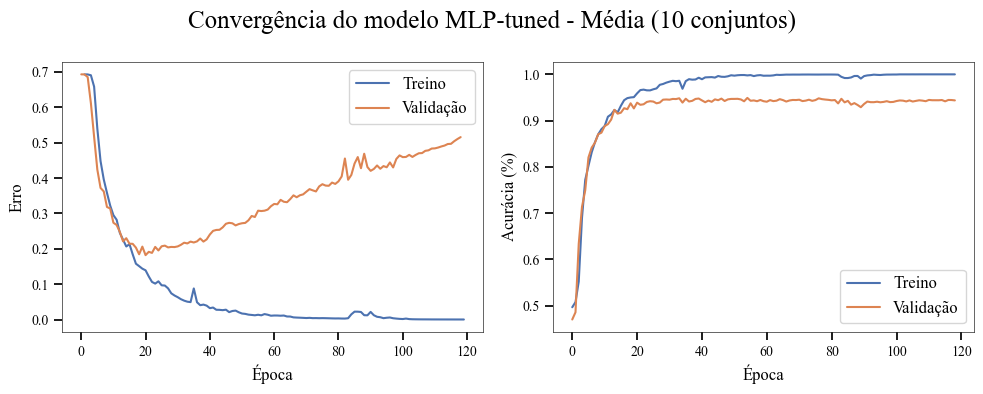

In [111]:
#plotar gráficos de todos os fits
keys = list(fits_MLP[0].history.keys())
for i, fit_MLP in enumerate(fits_MLP):
    plt.clf()
    fig11 = plt.figure(figsize=(10,4))
    plt.suptitle('Convergência do modelo MLP-tuned - Fold: '+str(i+1))
    plt.subplot(1,2,1)
    x1 = np.arange(1, len(fit_MLP.history[keys[0]]) + 1)
    plt.plot(x1, fit_MLP.history[keys[0]])
    plt.plot(fit_MLP.history[keys[2]])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel('Épocas')
    plt.ylabel('Erro')
    plt.subplot(1,2,2)
    plt.plot(fit_MLP.history[keys[1]])
    plt.plot(fit_MLP.history[keys[3]])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.show()
    fig11.savefig('outputs_fig/fig11_convergencia_MLP_tuned_fold_'+str(i+1)+'.png')

#plotar gráfico médio
min_shape = min([len(fit_MLP.history[keys[0]]) for fit_MLP in fits_MLP])
mean_history_MLP = {}

for key in keys:
    mean_history_MLP[key] = np.reshape(fits_MLP[0].history[key][:min_shape], (-1, 1))
    for i in range(1, len(fits_MLP)):
        temp = np.reshape(fits_MLP[i].history[key][:min_shape], (-1, 1))
        mean_history_MLP[key] = np.mean([mean_history_MLP[key], temp], axis=0)
    
plt.clf()
fig11 = plt.figure(figsize=(10 ,4))
plt.suptitle(f'Convergência do modelo MLP-tuned - Média ({len(datasets)} conjuntos)')
plt.subplot(1,2,1)
x1 = np.arange(1, min_shape + 1)
plt.plot(x1, mean_history_MLP[keys[0]])
plt.plot(mean_history_MLP[keys[2]])
plt.legend(['Treino', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.subplot(1,2,2)
plt.plot(mean_history_MLP[keys[1]])
plt.plot(mean_history_MLP[keys[3]])
plt.legend(['Treino', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.show()
fig11.savefig('outputs_fig/fig11_convergencia_media_MLP_tuned.png')

In [112]:
print("MLP-tuned - Acurácia média: %.2f%% (+/- %.2f%%)" % (scores['MLP-tuned']['acc']['avg'], scores['MLP-tuned']['acc']['std']))

MLP-tuned - Acurácia média: 0.94% (+/- 0.01%)


#### CNN Tuning

In [116]:
clean_dir()
del hp
from keras_tuner import HyperParameters as hp
hp = hp()
hp.Int('batch_size', 32, 128, step=32)

es = EarlyStopping(monitor=monitor_er, verbose=1, patience=patience_tunning, restore_best_weights=True)
build_model_CNN = partial(build_model_CNN, input_units=input_units)

tuner_CNN = kt.Hyperband(build_model_CNN, objective,
                        directory='hyperband_tuner',
                        hyperparameters=hp,
                        max_epochs=epochs_tunning,
                        overwrite=True)
time = datetime.now()
tuner_CNN.search(datasets[0][0], datasets[0][2], validation_data=(datasets[0][1], datasets[0][3]),
                 epochs=epochs_tunning, verbose=1, callbacks=[es])
time_process = datetime.now() - time
print(f"Tempo de processamento: {time_process}")
#254 trials
#Time process: 68m 18.9s

Trial 254 Complete [00h 00m 48s]
val_loss: 0.4548830986022949

Best val_loss So Far: 0.12099771946668625
Total elapsed time: 01h 08m 18s
INFO:tensorflow:Oracle triggered exit


In [117]:
best_hps = tuner_CNN.get_best_hyperparameters(num_trials=2)[0]
best_model_CNN = tuner_CNN.hypermodel.build(best_hps)
best_model_CNN.summary()

best_hps_CNN = tuner_CNN.get_best_hyperparameters()[0].values
best_hps_CNN = dict(sorted(best_hps_CNN.items()))
print('Melhores parâmetros:\n')
print(best_hps_CNN)
      # 'lr: ', best_model_CNN.optimizer.lr.numpy())

#salvar dicionários com os melhores parâmetros
with open('results/best_hps_CNN.json', 'w') as f:
      best_hps_CNN = {k: v for k, v in best_hps_CNN.items() if 'tuner' not in k}
      json.dump(best_hps_CNN, f, indent=4)

best_model_CNN.save('results/best_model_CNN.h5py')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 123, 48)           240       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 48)           0         
 1D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 41, 48)           192       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 112)           21616     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 12, 112)          0         
 1D)                                                             
                                                      

INFO:tensorflow:Assets written to: results/best_model_CNN.h5py\assets


INFO:tensorflow:Assets written to: results/best_model_CNN.h5py\assets


#### CNN Classificação

In [119]:
#Treinando melhor modelo com CV

best_batch_size = tuner_CNN.get_best_hyperparameters()[0].values['batch_size']
es = EarlyStopping(monitor=monitor_er, verbose=1, patience=patience_fit, restore_best_weights=True)

fits_CNN = []
cvscores_CNN = []
fits, fprs, tprs, rocs_aucs, accs = [], [], [], [], []
recalls, specificitys, precisions, f1s = [], [], [], []
from datetime import datetime
time = datetime.now()
for dataset in datasets:
    print('\nFold: ', len(fits_CNN)+1)

    #carregar melhor modelo
    best_model_CNN = tf.keras.models.load_model('results/best_model_CNN.h5py')
    # best_model_CNN = tuner_CNN.hypermodel.build(best_hps)
    
    fit_CNN = best_model_CNN.fit(dataset[0], dataset[2], validation_split=0.2, batch_size=best_batch_size,
                                 epochs = epochs_fit, callbacks = [es])
    fits_CNN.append(fit_CNN)

    y_pred = best_model_CNN.predict(dataset[1]).reshape(-1)
    
    #Calcular Acurácia, Sensibildiade/Recall, Especificidade, Precisão e F1
    eval = get_evaluations(dataset[3], y_pred)
    fprs.append(eval['fpr']), tprs.append(eval['tpr']), rocs_aucs.append(eval['roc_auc'])
    accs.append(eval['acc'])
    recalls.append(eval['recall'])
    specificitys.append(eval['specificity'])
    precisions.append(eval['precision'])
    f1s.append(eval['f1'])

acc_scores = save_acc_scores(acc_scores, 'CNN-tuned', accs)
scores = save_avg_eval(scores, 'CNN-tuned', fprs, tprs, rocs_aucs, accs, recalls, specificitys, precisions, f1s)
time_process = datetime.now() - time
print(f"Tempo de processamento: {time_process}")
#Time process: 21m 35.6s


Fold:  1
Epoch 1/1000
26/26 [==============================] - 4s 63ms/step - loss: 0.6239 - accuracy: 0.6620 - val_loss: 0.6878 - val_accuracy: 0.5267
Epoch 2/1000
26/26 [==============================] - 1s 40ms/step - loss: 0.3416 - accuracy: 0.8541 - val_loss: 0.6812 - val_accuracy: 0.5291
Epoch 3/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.2652 - accuracy: 0.8906 - val_loss: 0.6738 - val_accuracy: 0.7112
Epoch 4/1000
26/26 [==============================] - 1s 28ms/step - loss: 0.1727 - accuracy: 0.9422 - val_loss: 0.8003 - val_accuracy: 0.4757
Epoch 5/1000
26/26 [==============================] - 1s 28ms/step - loss: 0.1414 - accuracy: 0.9489 - val_loss: 0.9908 - val_accuracy: 0.4733
Epoch 6/1000
26/26 [==============================] - 1s 27ms/step - loss: 0.1206 - accuracy: 0.9538 - val_loss: 0.6655 - val_accuracy: 0.5049
Epoch 7/1000
26/26 [==============================] - 1s 25ms/step - loss: 0.0738 - accuracy: 0.9799 - val_loss: 1.0508 - val_accura

<Figure size 640x480 with 0 Axes>

C:\Users\abner\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


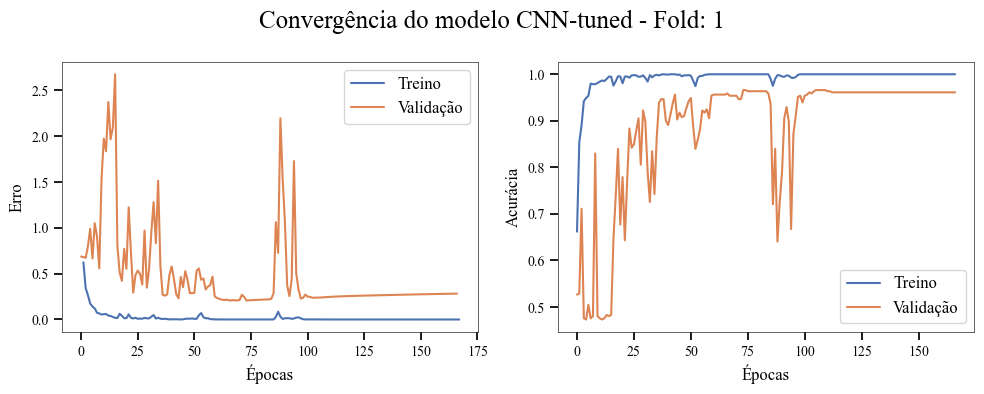

<Figure size 640x480 with 0 Axes>

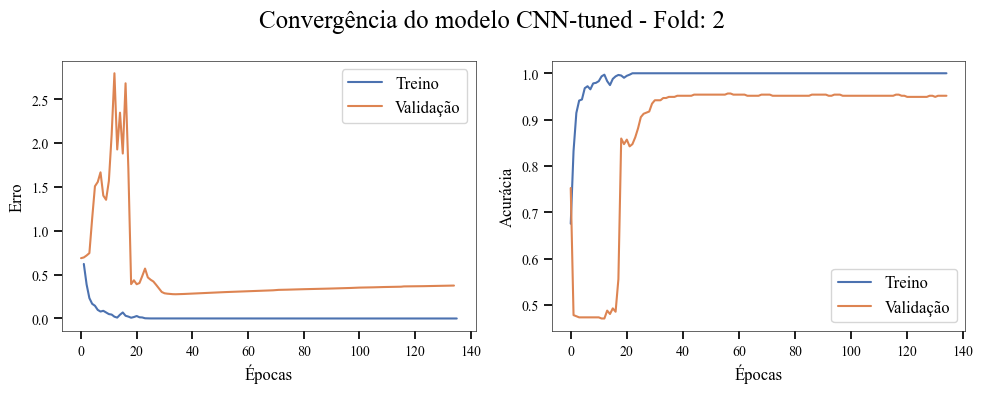

<Figure size 640x480 with 0 Axes>

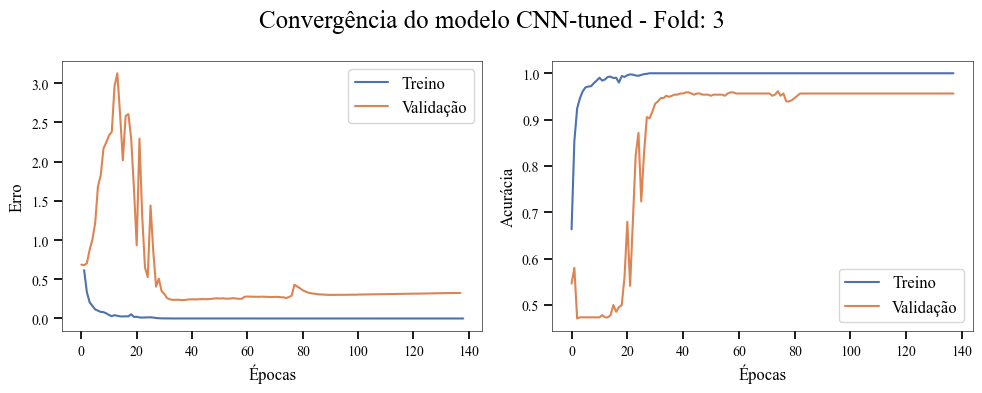

<Figure size 640x480 with 0 Axes>

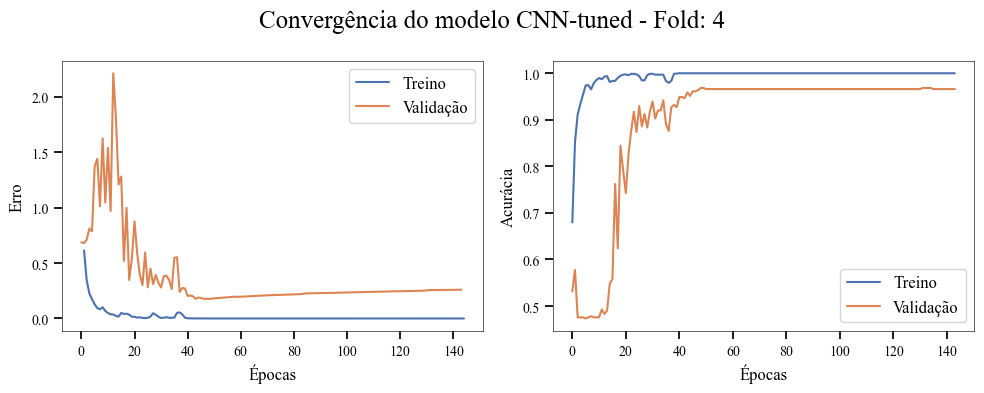

<Figure size 640x480 with 0 Axes>

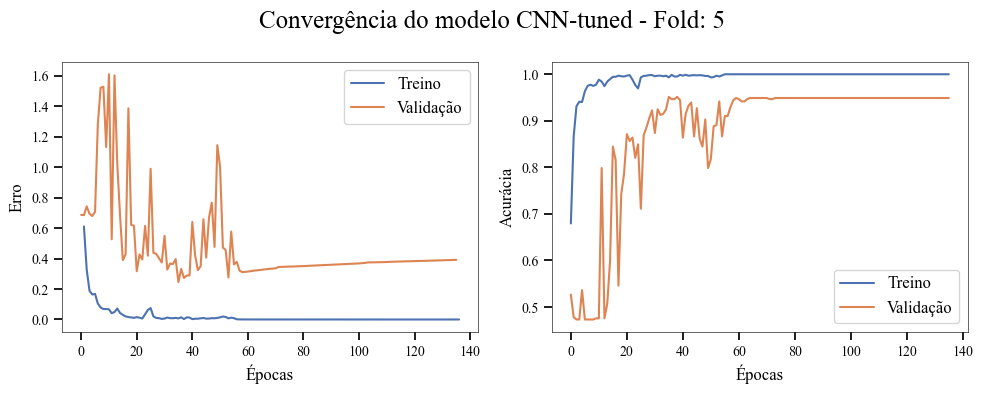

<Figure size 640x480 with 0 Axes>

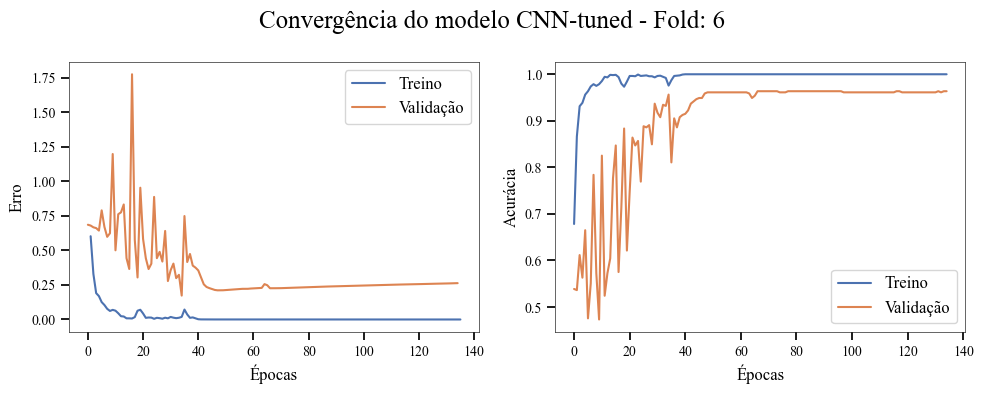

<Figure size 640x480 with 0 Axes>

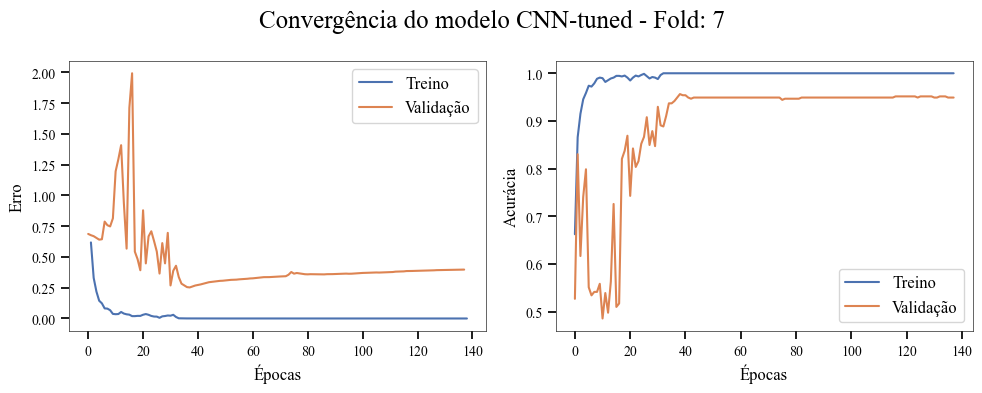

<Figure size 640x480 with 0 Axes>

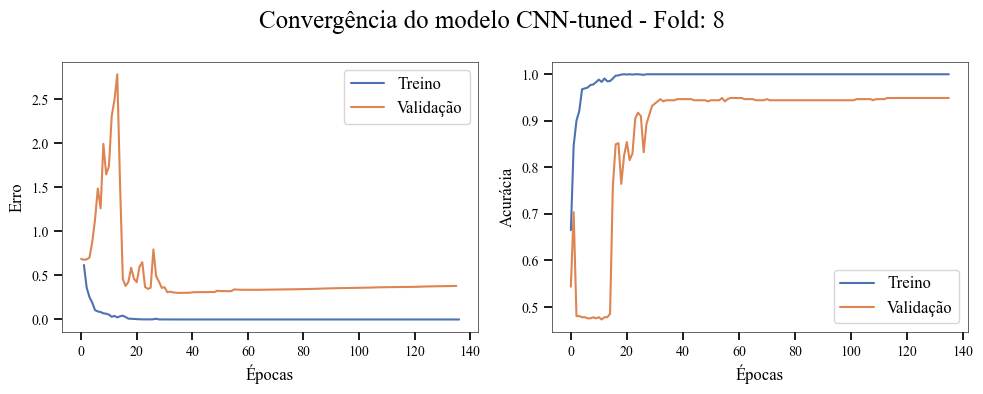

<Figure size 640x480 with 0 Axes>

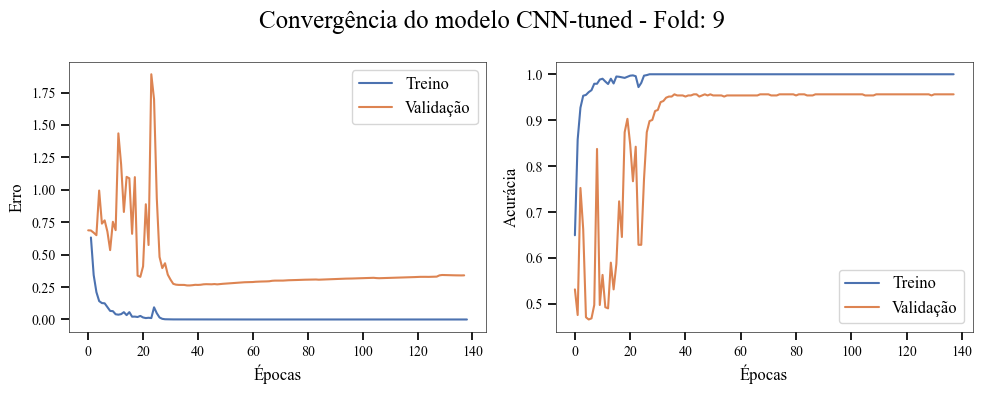

<Figure size 640x480 with 0 Axes>

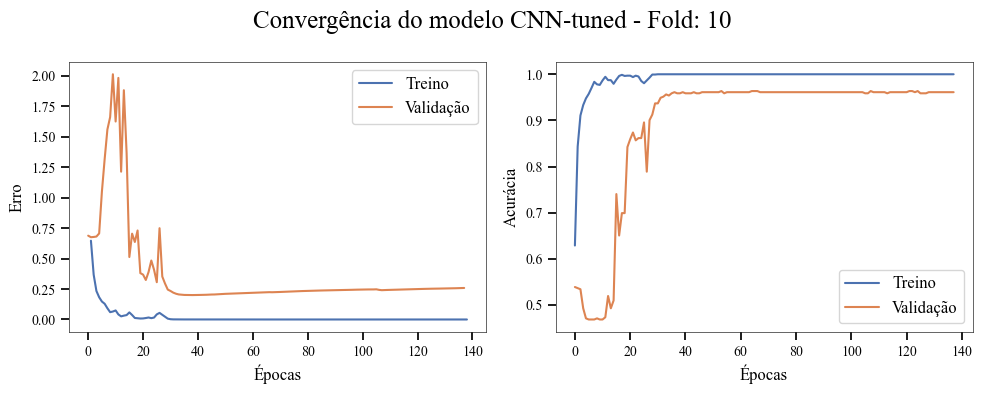

<Figure size 640x480 with 0 Axes>

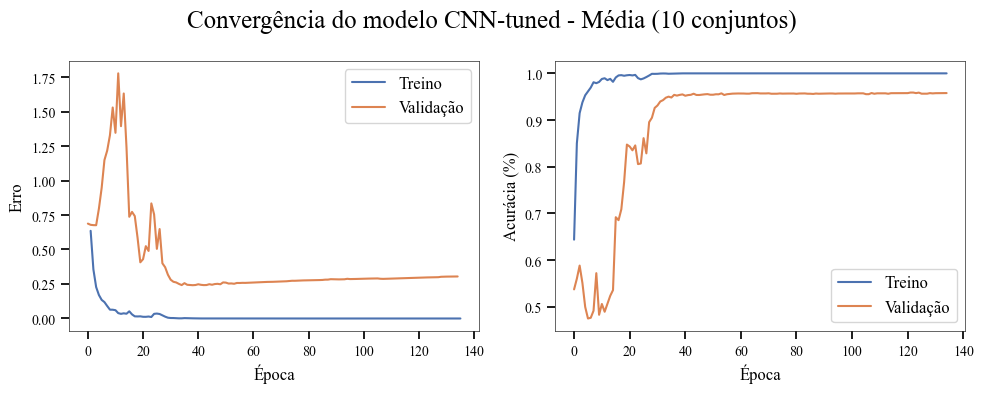

In [120]:
# Plotar gráficos de todos os fits
keys = list(fits_CNN[0].history.keys())
for i, fit_CNN in enumerate(fits_CNN):
    plt.clf()
    fig12 = plt.figure(figsize=(10,4))
    plt.suptitle('Convergência do modelo CNN-tuned - Fold: '+str(i+1))
    plt.subplot(1,2,1)
    x1 = np.arange(1, len(fit_CNN.history[keys[0]]) + 1)
    plt.plot(x1, fit_CNN.history[keys[0]])
    plt.plot(fit_CNN.history[keys[2]])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel('Épocas')
    plt.ylabel('Erro')
    plt.subplot(1,2,2)
    plt.plot(fit_CNN.history[keys[1]])
    plt.plot(fit_CNN.history[keys[3]])
    plt.legend(['Treino', 'Validação'])
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.show()
    fig12.savefig('outputs_fig/fig12_convergencia_CNN_tuned_fold_'+str(i+1)+'.png')

# Plotar gráfico médio
min_shape = min([len(fit_CNN.history[keys[0]]) for fit_CNN in fits_CNN])
mean_history_CNN = {}

for key in keys:
    mean_history_CNN[key] = np.reshape(fits_CNN[0].history[key][:min_shape], (-1, 1))
    for i in range(1, len(fits_CNN)):
        temp = np.reshape(fits_CNN[i].history[key][:min_shape], (-1, 1))
        mean_history_CNN[key] = np.mean([mean_history_CNN[key], temp], axis=0)
    
plt.clf()
fig12 = plt.figure(figsize=(10,4))
plt.suptitle(f'Convergência do modelo CNN-tuned - Média ({len(datasets)} conjuntos)')
plt.subplot(1,2,1)
x1 = np.arange(1, min_shape + 1)
plt.plot(x1, mean_history_CNN[keys[0]])
plt.plot(mean_history_CNN[keys[2]])
plt.legend(['Treino', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.subplot(1,2,2)
plt.plot(mean_history_CNN[keys[1]])
plt.plot(mean_history_CNN[keys[3]])
plt.legend(['Treino', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.show()
fig12.savefig('outputs_fig/fig12_convergencia_media_CNN_tuned.png')

In [121]:
print("CNN-tuned - Acurácia média: %.2f%% (+/- %.2f%%)" % (scores['CNN-tuned']['acc']['avg'], 
                                                           scores['CNN-tuned']['acc']['std']))

CNN-tuned - Acurácia média: 0.95% (+/- 0.01%)


### Outros

#### Regressão Logística, Knn, SVM, Árvore de Decisão

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}
from datetime import datetime
for key, classifier in classifiers.items():

    time = datetime.now()
    fits, fprs, tprs, rocs_aucs, accs = [], [], [], [], []
    recalls, specificitys, precisions, f1s = [], [], [], []
    for dataset in datasets:
        fit_cl = classifier.fit(dataset[0], dataset[2])
        fits.append(fit_cl)

        y_pred = classifier.predict(dataset[1])

        #Calcular Acurácia, Sensibildiade/Recall, Especificidade, Precisão e F1
        eval = get_evaluations(dataset[3], y_pred)
        fprs.append(eval['fpr']), tprs.append(eval['tpr']), rocs_aucs.append(eval['roc_auc'])
        accs.append(eval['acc'])
        recalls.append(eval['recall'])
        specificitys.append(eval['specificity'])
        precisions.append(eval['precision'])
        f1s.append(eval['f1'])
    time_process = datetime.now() - time
    print(key, f"\t - Tempo de processamento: {time_process}")
    acc_scores = save_acc_scores(acc_scores, key, accs)
    scores = save_avg_eval(scores, key, fprs, tprs, rocs_aucs, accs, recalls, specificitys, precisions, f1s)

    print(key, f"\t - Acurácia média: %.2f%% (+/- %.2f%%)" % (scores[key]['acc']['avg'], scores[key]['acc']['std']))

LR 	 - Tempo de processamento: 0:00:00.498182
LR 	 - Acurácia média: 0.79% (+/- 0.02%)
DT 	 - Tempo de processamento: 0:00:03.651068
DT 	 - Acurácia média: 0.86% (+/- 0.02%)
KNN 	 - Tempo de processamento: 0:00:00.502677
KNN 	 - Acurácia média: 0.88% (+/- 0.02%)
SVM 	 - Tempo de processamento: 0:00:04.597124
SVM 	 - Acurácia média: 0.87% (+/- 0.02%)


### Comparação de modelos

In [3]:
# Carregar os resultados
with open('results/resultados.json') as json_file:
      scores = json.load(json_file)

with open('results/acuracias.json') as json_file:
      acc_scores = json.load(json_file)

C:\Users\abner\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


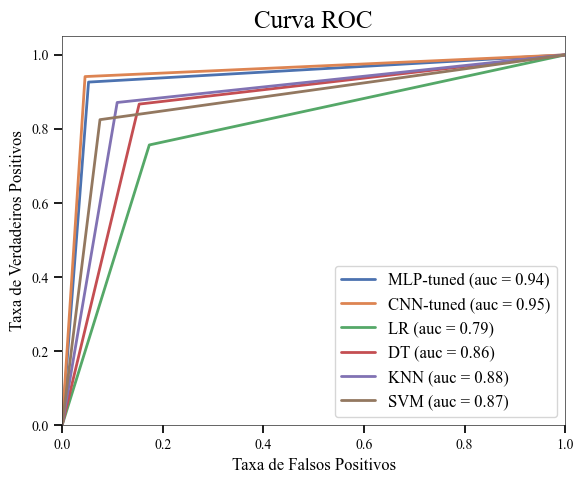

In [15]:
fig15 = plt.figure(figsize=(6, 5))

for i, (key, result) in enumerate(scores.items()):
    plt.plot(result['roc']['avg']['taxa_fp'], result['roc']['avg']['taxa_tp'], lw=2,
               label=f"{key} (auc = {result['roc']['avg']['roc_auc']:0.2f})")
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc="lower right")
plt.title('Curva ROC')
plt.show()
fig15.savefig('outputs_fig/fig15_comparacao_modelos.png')

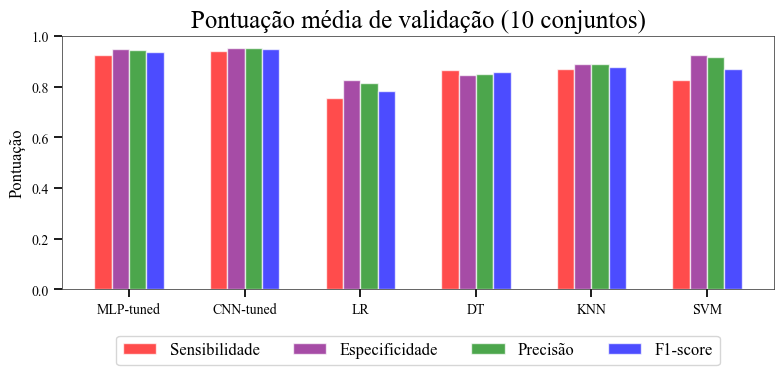

In [16]:
fig16 = plt.figure(figsize=(8, 4))
x = np.arange(1, len(scores)+1)
w_col = .6
w_bar = w_col / 4

for i, (key, result) in enumerate(scores.items()):
    plt.bar(i+1-w_bar*2, result['recall']['avg'], width=w_bar, color='red', align='edge', label='Sensibilidade', alpha=.7)
    # plt.text(i+1, result['recall']['avg'], result['recall']['avg'])
    plt.bar(i+1-w_bar, result['specificity']['avg'], width=w_bar, color='purple', align='edge', label='Especificidade', alpha=.7)
    # plt.text(i+1, result['recall']['avg'], result['recall']['avg'])
    plt.bar(i+1, result['precision']['avg'], width=w_bar, color='green', align='edge', label='Precisão', alpha=.7)
    # plt.text(i+1-w_col/4, result['precisao']['avg'], result['precisao']['avg'])
    plt.bar(i+1+w_bar, result['f1']['avg'], width=w_bar, color='blue', align='edge', label='Pontuação F1', alpha=.7)
    # plt.text(i+1+w_col/4, result['f1']['avg'], result['f1']['avg'])
    
plt.title(f'Pontuação média de validação ({len(list(acc_scores.values())[0])} conjuntos)')
plt.ylabel('Pontuação')
plt.xticks(x, labels=list(scores.keys()))
plt.legend(['Sensibilidade', 'Especificidade', 'Precisão', 'F1-score'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()
fig16.savefig('outputs_fig/fig16_pontuacoes_modelos.png')

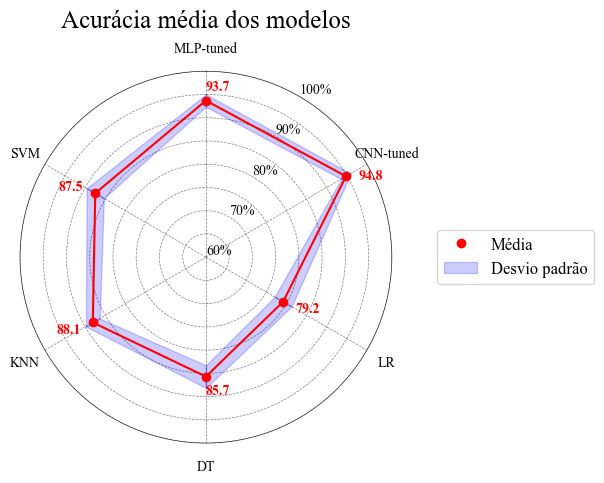

In [17]:
#Plot acurácia no formato radar
fig17 = plt.figure(figsize=(6,5))
ax = fig17.add_subplot(111, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_title('Acurácia média dos modelos', va='bottom')
ax.set_ylim(0.6, 1)
ax.set_yticks([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
ax.set_yticklabels(['60%', '', '70%', '', '80%', '', '90%', '', '100%'])
ax.set_xticks(np.linspace(0, 2*np.pi, len(scores.keys())+1)[:-1], list(scores.keys()))
ax.set_xticklabels(list(scores.keys()), )
ax.set_rlabel_position(30)

fig17.set_tight_layout(False)
for i, (key, result) in enumerate(scores.items()):
    # média
    ax.plot([i*(2*np.pi/len(scores.keys()))], [result['acc']['avg']], 'o', color='red') #ponto
    # desvio padrão
    ax.fill_between([i*(2*np.pi/len(scores.keys())), (i-1)*(2*np.pi/len(scores.keys()))],
                    [result['acc']['avg']-result['acc']['std'], list(scores.values())[i-1]['acc']['avg']-list(scores.values())[i-1]['acc']['std']],
                    [result['acc']['avg']+result['acc']['std'], list(scores.values())[i-1]['acc']['avg']+list(scores.values())[i-1]['acc']['std']],
                    color='blue', alpha=0.2)
    # linha
    ax.plot([i*(2*np.pi/len(scores.keys())), (i-1)*(2*np.pi/len(scores.keys()))], 
            [result['acc']['avg'], list(scores.values())[i-1]['acc']['avg']], 
            color='red')
    ax.text(i*(2*np.pi/len(scores.keys())), result['acc']['avg']+0.03, f"{result['acc']['avg']*100:.1f}", 
            color='red', fontsize=10, fontweight='bold',
            va=['center', 'top', 'center', 'center', 'center', 'center'][i],
            ha=['left', 'left', 'left', 'left', 'right', 'right'][i])
plt.legend(['Média', 'Desvio padrão'], loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.show()
fig17.savefig('outputs_fig/fig17_acuracia_modelos.png')

#### Teste de hipótese

In [25]:
#PRESSUPOSIÇÃO 1: NORMALIDADE DAS DIFERENÇAS
# Verifica distribuição normal com o Shapiro-Wilk
print('-------- Shapiro-Wilk --------')
for i, (key, results) in enumerate(acc_scores.items()):
    if i < 2:
       print(f"{key}\t - W = {shapiro(results)[0]:5f}, p = {shapiro(results)[1]:5f}")

# Hipótese nula: a distribuição dos dados como um todo se desvia de uma distribuição normal
# Hipótese secundária: os dados como um todo possuem uma distribuição normal
# não significativo (p > 0,05)
# significativo (p < 0,05)
print('\nInterpretação para o teste distribuição normal:')
if shapiro(acc_scores['MLP-tuned'])[1] > 0.05:
    print(f'\tMLP-tuned - Não significativo (p > 0.05)')
else:
    print(f'\tMLP-tuned - Significativo (p < 0.05)')
if shapiro(acc_scores['CNN-tuned'])[1] > 0.05:
    print(f'\tCNN-tuned - Não significativo (p > 0.05)')
else:
    print(f'\tCNN-tuned - Significativo (p < 0.05)')
if shapiro([y - x for y, x in zip(acc_scores['MLP-tuned'], acc_scores['CNN-tuned'])])[1] > 0.05:
    print(f'\tDiferença - Não significativo (p > 0.05)')
else:
    print(f'\tDiferença - Significativo (p < 0.05)')

-------- Shapiro-Wilk --------
MLP-tuned	 - W = 0.938512, p = 0.536583
CNN-tuned	 - W = 0.915534, p = 0.321210

Interpretação para o teste distribuição normal:
	MLP-tuned - Não significativo (p > 0.05)
	CNN-tuned - Não significativo (p > 0.05)
	Diferença - Não significativo (p > 0.05)


<Figure size 640x480 with 0 Axes>

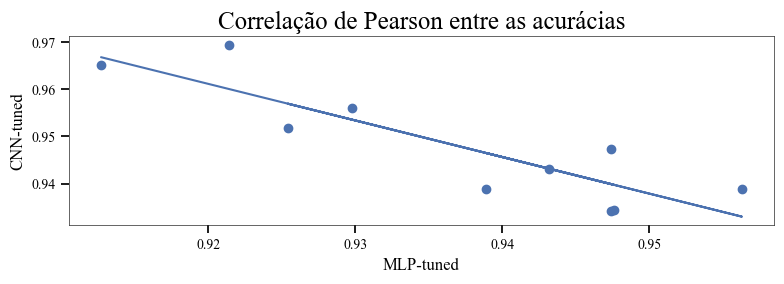

-------- Correlação de Pearson --------
MLP-tuned x CNN-tuned - r = -0.872661,  p = 0.000984

Interpretação para o teste de correlação:
	MLP-tuned x CNN-tuned - Significativo (p < 0.05)


In [41]:
#PRESSUPOSIÇÃO 2: DEPENDÊNCIA LINEAR ENTRE AS AMOSTRAS
# Visualizar se as variáveis possuem um relação linear
plt.clf()
fig18 = plt.figure(figsize=(8, 3))
plt.scatter(acc_scores['MLP-tuned'], acc_scores['CNN-tuned'])
z = np.polyfit(acc_scores['MLP-tuned'], acc_scores['CNN-tuned'], 1)
p = np.poly1d(z)
plt.plot(acc_scores['MLP-tuned'], p(acc_scores['MLP-tuned']))
plt.xlabel('MLP-tuned')
plt.ylabel('CNN-tuned')
plt.title('Correlação de Pearson entre as acurácias')
plt.show()
fig18.savefig('outputs_fig/fig18_correlacao_pearson.png')

# Confirmar dependência com correlação de Pearson
r = pearsonr(acc_scores['MLP-tuned'], acc_scores['CNN-tuned'])
print('-------- Correlação de Pearson --------')
print(f"MLP-tuned x CNN-tuned - r = {r[0]:5f},  p = {r[1]:5f}")

# Hipótese nula: não existe correlação entre as variáveis
# Hipótese secundária: existe correlação entre as variáveis
# não significativo (p > 0,05)
# significativo (p < 0,05)
print('\nInterpretação para o teste de correlação:')
if r[1] > 0.05:
    print(f'\tMLP-tuned x CNN-tuned - Não significativo (p > 0.05)')
else:
    print(f'\tMLP-tuned x CNN-tuned - Significativo (p < 0.05)')

<Figure size 640x480 with 0 Axes>

C:\Users\abner\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


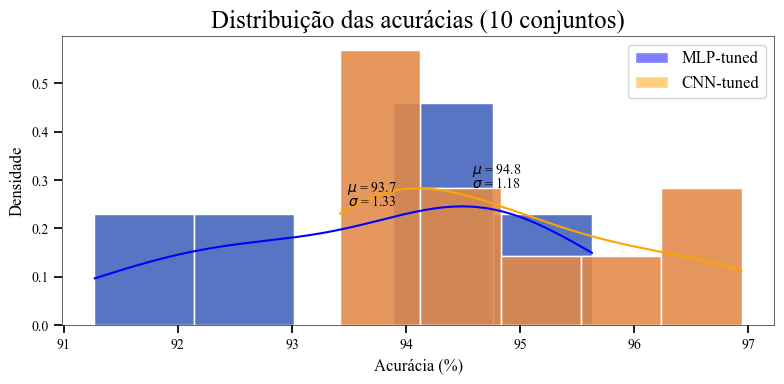

In [36]:
# Plot da distribuição das acurácias
# plt.clf()
# fig19 = plt.figure(figsize=(10, 4))
# for i, (key, results) in enumerate(acc_scores.items()):
#     fig19.add_subplot(1, len(acc_scores.items()), i+1)
#     sns.histplot(results, kde=True, stat="density")
#     plt.title(key)
#     plt.xlabel('Acurácia')
#     plt.ylabel('Frequência')
# plt.show()
# fig19.savefig('outputs_fig/fig19_distribuicao_acuracias.png')

plt.clf()
fig19 = plt.figure(figsize=(8, 4))

for i, (key, results) in enumerate(acc_scores.items()):
    if i < 2:
        results = [x*100 for x in results]
        sns.histplot(results, kde=True, stat="density", label=key, color=['blue', 'orange'][i])
        freq_max = max(sns.histplot(results, stat="density").get_lines()[i].get_ydata())
        plt.text(np.mean(results), freq_max+0.03, r"$\mu$"+f" = {np.mean(results):.1f}", fontsize=10, ha='center')
        plt.text(np.mean(results), freq_max, r"$\sigma$"+f" = {np.std(results):.2f}", fontsize=10, ha='center')
plt.title(f'Distribuição das acurácias ({len(list(acc_scores.values())[0])} conjuntos)')
plt.legend()
plt.xlabel('Acurácia (%)')
plt.ylabel('Densidade')
plt.show()
fig19.savefig('outputs_fig/fig19_distribuicao_acuracias.png')

In [6]:
# Estatística t de Student pareado igual a para média de uma amostra
# delta0 = 0                     # hipótese nula: a média das diferenças é igual a zero
# n = len(diff)                  # tamanho da amostra
# t = (mu_diff - delta0) / sqrt(sigma_diff / nJ)

# Estatística t de Student pareado corrigido
# Diferença entre os resultados
diff = [y - x for y, x in zip(acc_scores['MLP-tuned'], acc_scores['CNN-tuned'])]
# Média das diferenças
mu_diff = np.mean(diff)
# Variação das diferenças
sigma2 = np.var(diff, ddof=1)
# Tamanho do conjunto treinamento
n1 = len(datasets[0][2])
# Tamanho do conjunto teste
n2 = len(datasets[0][3])
# Tamanho da amostra (acurácias)
nJ = len(diff)
# Variação modificada
sigma2_mod = sigma2 * (1/nJ + n2/n1)
# Estatística t
t_static =  mu_diff / np.sqrt(sigma2_mod)

# Valor crítico
alpha = 0.05                    # nível de significância de 5%
gamma = 1.0 - alpha             # nível de confiança de 95%
df = nJ - 1                     # graus de liberdade (número de amostras - 1)
critical_v = t.ppf(gamma, df)

#Calcular o p-valor
p_value = ((1 - t.cdf(abs(t_static), df))*200)

print(f'Estatística t:\t{t_static:6f}')
print(f'Valor crítico:\t{critical_v:6f}')
print(f'Valor de p:\t{p_value:6f}')

# Hipótese nula: a diferenciação das acurácias médias é igual a zero
# Hipótse secundária: a média das acurácias possuem diferenças significativas
# não significativo (p > 0,05)
# significativo (p < 0,05)

print('\nInterpretação do Test t pelo valor crítico:')
if abs(t_static) <= critical_v:
    print(f'\tHipótese nula aceita.')
else:
    print(f'\tHipótese nula rejeitada')
print('Interpretação do Test t pelo valor de p:')
if p_value > alpha:
    print(f'\tHipótese nula aceita.')
else:
    print(f'\tHipótese nula rejeitada')

Estatística t:	-0.930243
Valor crítico:	1.833113
Valor de p:	37.652253

Interpretação do Test t pelo valor crítico:
	Hipótese nula aceita.
Interpretação do Test t pelo valor de p:
	Hipótese nula aceita.


<Figure size 640x480 with 0 Axes>

C:\Users\abner\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


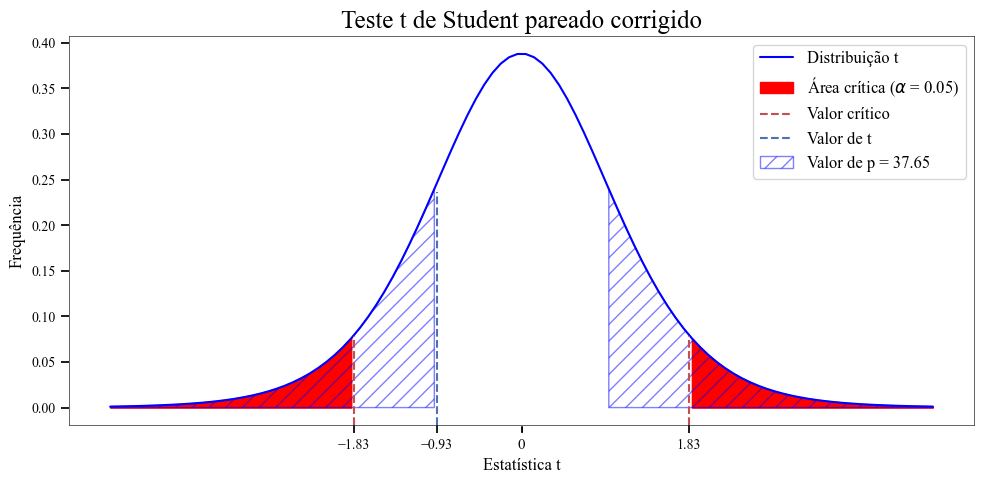

In [66]:
# Plot gráfico visualizando áreas do teste t pareado modificado
plt.clf()
fig20 = plt.figure(figsize=(10, 5))
x = np.linspace(-4.5, 4.5, 100)
x_stick = np.round([-critical_v, t_static, critical_v], 2)
y = t.pdf(x, nJ-1)
plt.plot(x, y, color='blue', label='Distribuição t')
plt.xticks(x_stick)
plt.text(0, -0.02, f"-", ha='center', fontsize=19, rotation=90)
plt.text(0, -0.045, f"0", ha='center', fontsize=11)
plt.fill_between(x, y, where=(x > critical_v), color='red', label=f'Área crítica ('+r'$\alpha$'+f' = {alpha})')
plt.fill_between(x, y, where=(x < -critical_v), color='red')
plt.axvline(x=critical_v, ymax=0.23, color='r', linestyle='--', label=f"Valor crítico")
plt.axvline(x=-critical_v, ymax=0.23, color='r', linestyle='--')
plt.axvline(x=t_static, ymax=0.6, color='b', linestyle='--', label=f"Valor de t")
plt.fill_between(x, y, where=(x < t_static), color='blue', hatch='//', edgecolor='blue', facecolor='none', 
                 alpha=0.5, label=f"Valor de p = {p_value:.2f}")
#area de p com seguinte layout: hatch='//', edgecolor='blue', facecolor='none'
plt.fill_between(x, y, where=(x > -t_static), color='blue', hatch='//', edgecolor='blue', facecolor='none', alpha=0.5)
plt.legend()
plt.title('Teste t de Student pareado corrigido')
plt.xlabel('Estatística t')
plt.ylabel('Frequência')
plt.show()
fig20.savefig('outputs_fig/fig20_teste_hipotese.png')